In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.cn1 = nn.Conv2d(1, 16, 3, 1)
    self.cn2 = nn.Conv2d(16, 32, 3, 1)
    self.dp1 = nn.Dropout2d(0.10)
    self.dp2 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.cn1(x)
    x = F.relu(x)
    x = self.cn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)
    x = self.fc2(x)
    op = F.log_softmax(x, dim=1)
    return op


In [14]:
def train(model, device, train_loader, optim, epoch):
  model.train()
  for b_i, (X,y) in enumerate(train_loader):
    X,y = X.to(device), y.to(device)
    optim.zero_grad()
    pred_probs = model(X)
    loss = F.nll_loss(pred_probs, y)
    loss.backward()
    optim.step()
    if b_i % 1000 == 0:
      print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(epoch, b_i * len(X), len(train_loader.dataset), 100. * b_i / len(train_loader), loss.item()))


In [15]:
def test(model, device, test_loader):
  model.eval()
  loss = 0
  success = 0
  with torch.no_grad():
    for X, y in test_loader:
      pred_prob = model(X)
      loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
      pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
      success += pred.eq(y.view_as(pred)).sum().item()
    loss /= len(test_loader.dataset)
    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(loss, success, len(test_loader.dataset), 100. * success / len(test_loader.dataset)))

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1302,), (0.3069,))
    ])),
    batch_size=500, shuffle=False)

In [17]:
torch.manual_seed(0)
device = torch.device('cpu')
model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr= 0.5)
for epoch in range(1,3):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [32000/60000 (53%)]	 training loss: 0.009694

Test dataset: Overall Loss: 0.0492, Overall Accuracy: 9841/10000 (98%)

epoch: 2 [0/60000 (0%)]	 training loss: 0.066932
epoch: 2 [32000/60000 (53%)]	 training loss: 0.003104

Test dataset: Overall Loss: 0.0417, Overall Accuracy: 9861/10000 (99%)



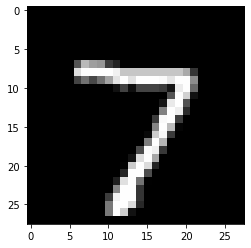

In [20]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)
plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')

In [19]:
print(f'Model prediction is : {model(sample_data).data.max(1)[1][0]}')

print(f'Ground truth is : {sample_targets[0]}')

Model prediction is : 7
Ground truth is : 7
